In [23]:
from scipy.stats import uniform
import datetime

import pandas as pd
import numpy as np

import json
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sktime.datatypes import convert_to

from sktime.dists_kernels import AggrDist, ScipyDist
from sktime.datasets import load_unit_test

from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.feature_selection import RFE

# Model import
from xgboost import XGBClassifier

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

<span style="font-size:1.5em;">Settings and pre-execution analysis functions</span>

In [ ]:
DESIGN = "fabscalar"
REPO_PATH = "/mnt/shared-scratch/Hu_J/minh.luu/github/vcdiag_fabscalar"

SIGNAL_DATA_PATH = f"{REPO_PATH}/vcd_extract/signals/fabscalar/numbered_signal_list.txt"
SIGNAL_DATA_PATH_PRUNED = f"{SIGNAL_DATA_PATH.replace('numbered_signal_list.txt', 'target_signals_xgb_pruned.txt')}"
DATA_ANALYSIS_PATH = f"{REPO_PATH}/data_analysis"
CONFIG_PATH = f"{REPO_PATH}/configs/{DESIGN}.json"
FINAL_BUG_DATA_PATH_TRAIN = f"{DATA_ANALYSIS_PATH}/data/final_data/train/"

TOP_PERCENTAGE = 0.60

In [25]:
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
sim_and_extract_config = config["sim_and_extract"]
extract_config = sim_and_extract_config["extract"]
BEFORE_FAILURE_TIMEFRAME = extract_config["line_limit"]

In [26]:
# Count the frequency of each label in the train label.csv
def count_label_frequency(label_file_path):
    label_freq = {}
    with open(label_file_path, 'r') as f:
        for line in f:
            label = line.split(',')[1].strip()
            if label not in label_freq:
                label_freq[label] = 1
            else:
                label_freq[label] += 1
    return label_freq


display(count_label_frequency(FINAL_BUG_DATA_PATH_TRAIN + "label.csv"))

{'FECHONE': 744,
 'FECHWO': 774,
 'DECODE': 651,
 'DISP': 382,
 'EXEC': 630,
 'INSBUF': 450,
 'ISSUE': 460,
 'LSU': 558,
 'MAPABLE': 528,
 'REGREAD': 641,
 'REIRE': 411,
 'RENAME': 387}

<span style="font-size:1.5em;">Support classes and functions</span>

In [27]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

<span style="font-size:1.5em;">Training</span>

<span style="font-size:1em;">Data import and preprocess</span>

In [28]:
# Read training data from csv
X_train = pd.read_csv(f"{FINAL_BUG_DATA_PATH_TRAIN}/data.csv")
label_train_df = pd.read_csv(
    f"{FINAL_BUG_DATA_PATH_TRAIN}/label.csv", index_col=0, header=None)
y_train = label_train_df.to_numpy().flatten()

# Drop column "instances" for both training and testing data
X_train = X_train.drop(columns=["instances"])

X_train_original = X_train.copy()
y_train_original = label_train_df.to_numpy().flatten()

In [29]:
from sklearn.model_selection import train_test_split

# # Split training to training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_original, y_train_original, test_size=0.3, random_state=42)

X_train = X_train_original.copy()
y_train = y_train_original.copy()

# cap the training dataset at 200 samples per class
X_train = X_train.copy()
y_train = y_train.copy()
X_train["label"] = y_train
X_train = X_train.groupby("label").head(3000)
y_train = X_train["label"]
X_train = X_train.drop(columns=["label"])

label_freq_train = {}
for label in y_train:
    if label not in label_freq_train:
        label_freq_train[label] = 1
    else:
        label_freq_train[label] += 1
        
label_freq_test = {}
for label in y_valid:
    if label not in label_freq_test:
        label_freq_test[label] = 1
    else:
        label_freq_test[label] += 1
       
display(label_freq_train)
display(label_freq_test)

{'FECHONE': 744,
 'FECHWO': 774,
 'DECODE': 651,
 'DISP': 382,
 'EXEC': 630,
 'INSBUF': 450,
 'ISSUE': 460,
 'LSU': 558,
 'MAPABLE': 528,
 'REGREAD': 641,
 'REIRE': 411,
 'RENAME': 387}

{'ISSUE': 138,
 'REIRE': 126,
 'REGREAD': 176,
 'FECHWO': 236,
 'INSBUF': 148,
 'FECHONE': 240,
 'EXEC': 186,
 'RENAME': 124,
 'LSU': 158,
 'DECODE': 191,
 'DISP': 104,
 'MAPABLE': 158}

In [30]:
# convert all labels to float
le = LabelEncoder()
y_train_float = le.fit_transform(y_train)
y_valid_float = le.transform(y_valid)

# prep stats
classes = np.unique(y_train_float)
n_classes = len(classes)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_float
)

display(f"Weights: {class_weights}")
class_weights = {i: class_weights[i] for i in range(n_classes)}
max_delta_step = 1

'Weights: [0.8469022  1.44328098 0.87513228 0.74103943 0.71231697 1.22518519\n 1.19855072 0.98805257 1.04419192 0.8601144  1.34144363 1.42463394]'

In [31]:
columns_to_drop = [name for name in X_train.columns if any([name.endswith(suffix) for suffix in ["_lol_"]])]

X_train = X_train.drop(columns=columns_to_drop)
X_valid = X_valid.drop(columns=columns_to_drop)

In [32]:
display(X_train.head())
display(X_train.shape)
display(y_train)

,1__0.1,1__0.3,1__0.9,1__kurt,1__max,1__mean,1__min,2__0.1,2__0.3,2__0.9,...,4860__max,4860__mean,4860__min,4861__0.1,4861__0.3,4861__0.9,4861__kurt,4861__max,4861__mean,4861__min
0,210210.0,215630.0,231890.0,-1.2,234600.0,221050.0,207500.0,235.0,235.0,236.0,...,91.0,7.184162,1.0,22.0,22.0,22.0,0.0,22.0,22.0,22.0
1,293110.0,298530.0,314790.0,-1.2,317500.0,303950.0,290400.0,495.0,495.0,547.0,...,95.0,5.158379,1.0,22.0,22.0,22.0,0.0,22.0,22.0,22.0
2,10110.0,15530.0,31790.0,-1.2,34500.0,20950.0,7400.0,2.0,2.0,101.0,...,95.0,2.845304,1.0,34.0,34.0,34.0,0.0,34.0,34.0,34.0
3,50810.0,56230.0,72490.0,-1.2,75200.0,61650.0,48100.0,162.0,166.0,196.0,...,88.0,3.593002,1.0,22.0,22.0,22.0,0.0,22.0,22.0,22.0
4,210210.0,215630.0,231890.0,-1.2,234600.0,221050.0,207500.0,235.0,235.0,236.0,...,91.0,7.184162,1.0,22.0,22.0,22.0,0.0,22.0,22.0,22.0


(6616, 34027)

0       FECHONE
1       FECHONE
2       FECHONE
3       FECHONE
4       FECHONE
5       FECHONE
6       FECHONE
7       FECHONE
8       FECHONE
9       FECHONE
10      FECHONE
11      FECHONE
12      FECHONE
13      FECHONE
14      FECHONE
15      FECHONE
16      FECHONE
17      FECHONE
18      FECHONE
19      FECHONE
20      FECHONE
21      FECHONE
22      FECHONE
23      FECHONE
24      FECHONE
25      FECHONE
26      FECHONE
27      FECHONE
28      FECHONE
29      FECHONE
30      FECHONE
31      FECHONE
32      FECHONE
33      FECHONE
34      FECHONE
35      FECHONE
36      FECHONE
37      FECHONE
38      FECHONE
39      FECHONE
40      FECHONE
41      FECHONE
42      FECHONE
43      FECHONE
44      FECHONE
45      FECHONE
46      FECHONE
47      FECHONE
48      FECHONE
49      FECHONE
50      FECHONE
51      FECHONE
52      FECHONE
53      FECHONE
54      FECHONE
55      FECHONE
56      FECHONE
57      FECHONE
58      FECHONE
59      FECHONE
60      FECHONE
61      FECHONE
62      

<span style="font-size:1em;">ML model definition and training</span>

In [33]:
import torch
cuda_available = torch.cuda.is_available()
device = 'cpu' if not cuda_available else 'cuda'
display(device)

'cuda'

In [34]:
# XGBoost parameters
xgboost_params = {
    'objective': 'multi:multi:softprob',
    'num_class': len(np.unique(y_train_float)),
    'eval_metric': ["merror", "mlogloss"],
    # 'n_estimators': 500,
    'n_jobs': -1,
    'early_stopping_rounds': 10,
    'weight': class_weights,
    # 'max_delta_step': max_delta_step,
    'tree_method': 'gpu_hist' if cuda_available else 'auto',
    'predictor': 'gpu_predictor' if cuda_available else 'cpu_predictor'
}

In [35]:
# # Define the XGBoost classifier
model = XGBClassifier(**xgboost_params)
eval_set = [(X_train, y_train_float), (X_valid, y_valid_float)]

In [36]:
model.fit(X_train, y_train_float, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.24274	validation_0-mlogloss:1.57836	validation_1-merror:0.23526	validation_1-mlogloss:1.56544
[1]	validation_0-merror:0.13422	validation_0-mlogloss:1.20401	validation_1-merror:0.12393	validation_1-mlogloss:1.19188
[2]	validation_0-merror:0.10323	validation_0-mlogloss:0.97609	validation_1-merror:0.09622	validation_1-mlogloss:0.96278
[3]	validation_0-merror:0.08525	validation_0-mlogloss:0.80495	validation_1-merror:0.07758	validation_1-mlogloss:0.79544
[4]	validation_0-merror:0.07331	validation_0-mlogloss:0.67659	validation_1-merror:0.06801	validation_1-mlogloss:0.66793
[5]	validation_0-merror:0.06424	validation_0-mlogloss:0.57999	validation_1-merror:0.06096	validation_1-mlogloss:0.57198
[6]	validation_0-merror:0.05804	validation_0-mlogloss:0.50138	validation_1-merror:0.05642	validation_1-mlogloss:0.49528
[7]	validation_0-merror:0.05260	validation_0-mlogloss:0.43976	validation_1-merror:0.05189	validation_1-mlogloss:0.43430
[8]	validation_0-merror:0.04625	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_class=12, num_parallel_tree=None, ...)

<span style="font-size:1.5em;">Testing</span>

In [37]:
results = model.evals_result()

# Graph the training and testing error
train_error = results["validation_0"]["merror"]
test_error = results["validation_1"]["merror"]
train_logloss = results["validation_0"]["mlogloss"]
test_logloss = results["validation_1"]["mlogloss"]

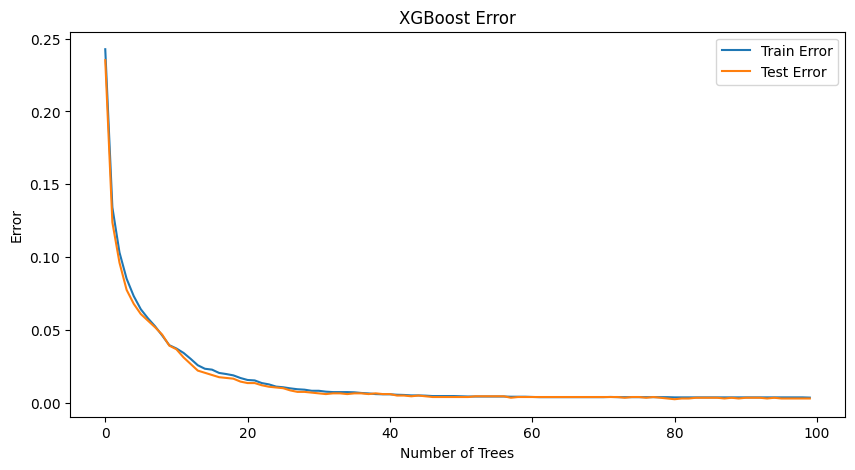

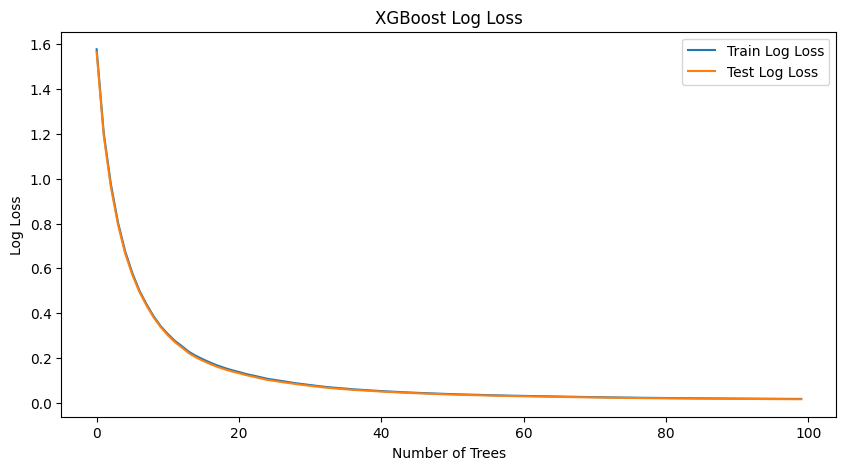

In [38]:
# Plot classification error
plt.figure(figsize=(10, 5))
plt.plot(train_error, label="Train Error")
plt.plot(test_error, label="Test Error")
plt.xlabel("Number of Trees")
plt.ylabel("Error")
plt.title("XGBoost Error")
plt.legend()
plt.show()

# Plot log loss
plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label="Train Log Loss")
plt.plot(test_logloss, label="Test Log Loss")
plt.xlabel("Number of Trees")
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.legend()
plt.show()

In [39]:
y_pred_float = model.predict(X_valid)

# if this is binary classification, np.argmax is needed
if n_classes == 2:
    y_pred_float = np.argmax(y_pred_float, axis=1)

y_pred = le.inverse_transform(y_pred_float)
y_pred_proba = model.predict_proba(X_valid)

0.996977329974811
0.9994962216624685


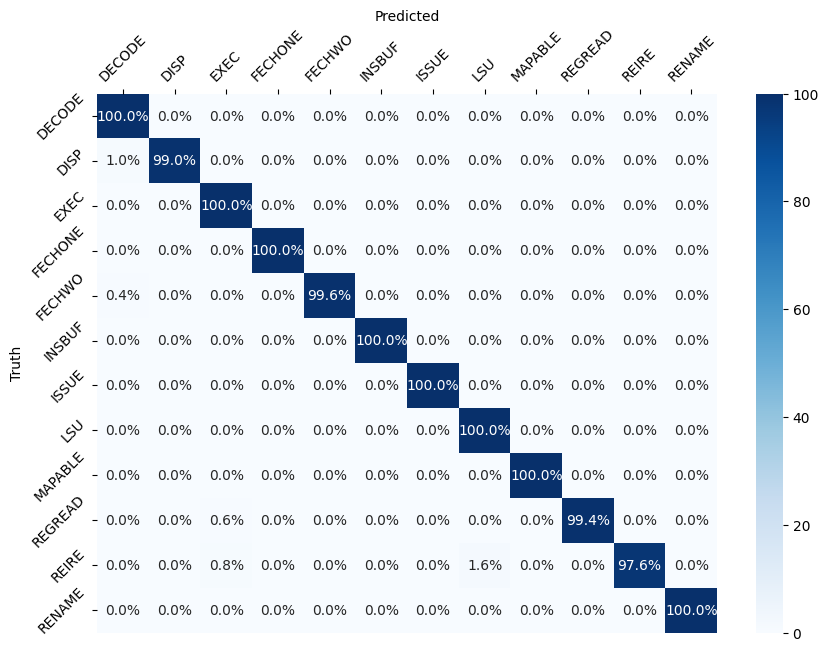

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, top_k_accuracy_score

acs = accuracy_score(y_valid, y_pred)
cm = confusion_matrix(y_valid, y_pred)
# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cr = classification_report(y_valid, y_pred, digits=4, output_dict=True)
top3_acs = top_k_accuracy_score(y_valid, y_pred_proba, k=3 if n_classes > 3 else n_classes)

print(acs)
print(top3_acs)

# Convert integer labels for the confusion matrix to string labels
labels = np.unique(y_train)

# Plot confusion matrix with seaborn
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt=".1f", cmap='Blues',
                 xticklabels=labels, yticklabels=labels)
# Add % sign to heatmap
for t in ax.texts:
    t.set_text(t.get_text() + "%")
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', rotation=45)

ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.tick_params(axis='y', rotation=45)


# Save the confusion matrix and classification report to a file
# Create a folder to store the logs if it does not exist
if not os.path.exists(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs"):
    os.makedirs(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs")
plt.savefig(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/cm_xgb_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png", bbox_inches='tight', dpi=150)
# round to 4 decimal places for better readability
cr_df = pd.DataFrame(cr).transpose().round(4)
cr_df.to_csv(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/cr_xgb_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv")

In [41]:
# Create a DataFrame to display the probabilities in a more descriptive way
df_prob = pd.DataFrame(y_pred_proba, columns=[
                       f'{class_name}_prob' for class_name in le.classes_])
df_prob['True_Label'] = y_valid
df_prob['Predicted_Label'] = y_pred

# Show only misclassified instances
df_prob = df_prob[df_prob['True_Label'] != df_prob['Predicted_Label']]

# Print the entire DataFrame
pd.set_option('display.max_rows', None)
display(df_prob)

,DECODE_prob,DISP_prob,EXEC_prob,FECHONE_prob,FECHWO_prob,INSBUF_prob,ISSUE_prob,LSU_prob,MAPABLE_prob,REGREAD_prob,REIRE_prob,RENAME_prob,True_Label,Predicted_Label
128,0.002106,0.001227,0.000244,0.000102,0.000087,0.000265,0.006627,0.503343,0.000129,0.004477,0.477459,0.003933,REIRE,LSU
309,0.000860,0.012519,0.005850,0.000874,0.000458,0.000180,0.000215,0.494789,0.002556,0.005146,0.472156,0.004396,REIRE,LSU
374,0.435414,0.329281,0.025462,0.030519,0.009698,0.012777,0.000185,0.109533,0.028943,0.011610,0.003351,0.003227,DISP,DECODE
892,0.005564,0.016210,0.316958,0.060063,0.023083,0.012624,0.001117,0.067120,0.029617,0.190862,0.257328,0.019454,REIRE,EXEC
968,0.004235,0.126372,0.148420,0.136773,0.136224,0.003639,0.132802,0.003622,0.034747,0.123206,0.132450,0.017510,REGREAD,EXEC
1558,0.445389,0.009647,0.123934,0.074765,0.141187,0.065204,0.000665,0.027768,0.045856,0.040679,0.013329,0.011577,FECHWO,DECODE


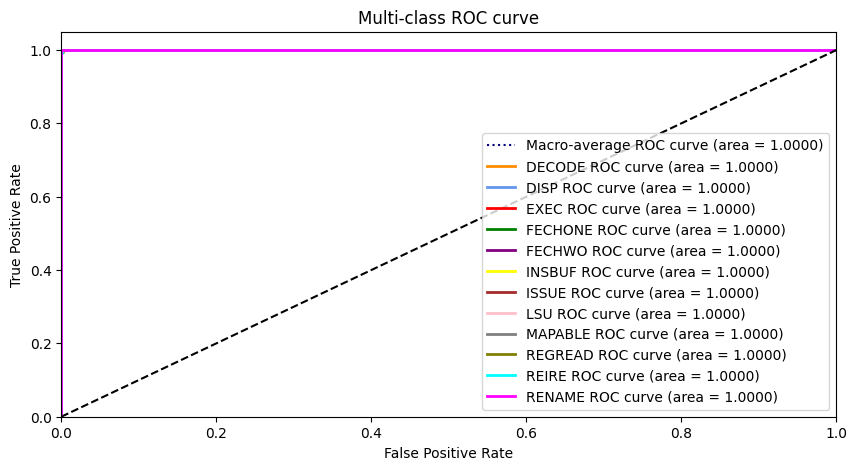

In [42]:
# Graph multi-class ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

n_classes = len(np.unique(y_train_float))
class_names = le.classes_
y_valid_bin = label_binarize(y_valid, classes=class_names)
y_pred_bin = y_pred_proba

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 5))
plt.plot(fpr["macro"], tpr["macro"], label="Macro-average ROC curve (area = {:.4f})".format(
    roc_auc["macro"]), color="navy", linestyle=":")
colors = cycle(["darkorange", "cornflowerblue", "red", "green", "purple",
               "yellow", "brown", "pink", "gray", "olive", "cyan", "magenta", "maroon"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label="{0} ROC curve (area = {1:.4f})".format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC curve")
plt.legend(loc="lower right")

# Save the ROC curve
plt.savefig(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/roc_xgb_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png", bbox_inches='tight', dpi=150)

plt.show()

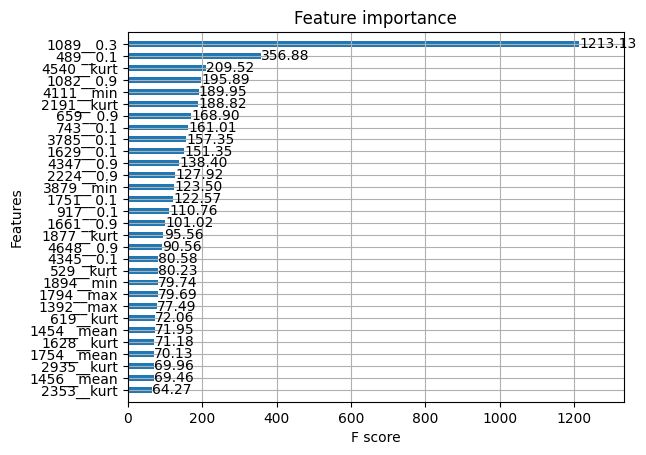

In [43]:
from xgboost import plot_importance

# BONUS for XGBoost: Feature importance
feature_names = X_train.columns
dict_features = dict(enumerate(feature_names))

# Get feature importance by named feature by weight
feature_importance = model.feature_importances_
feature_importance_named = {
    dict_features[i]: feature_importance[i] for i in range(len(feature_importance))}
feature_importance_named = dict(sorted(
    feature_importance_named.items(), key=lambda item: item[1], reverse=True))

# Calculate aggregated feature importance

axsub = plot_importance(model, importance_type="gain",
                        max_num_features=30, height=0.5, values_format="{v:.2f}")
# Plot feature importance by weight
plt.show()

In [44]:
display(len(feature_importance_named))
display(len(set(feature_importance_named.keys())))

all_features = set(feature_importance_named.keys())

top_features_statistics = dict(list(feature_importance_named.items())[
                    :int(len(feature_importance_named) * TOP_PERCENTAGE)])

print(f"Top features: {top_features_statistics}")

# strip away the postfixes (after __) to get the original feature names
top_features = {k.split("__")[0]: v for k, v in top_features_statistics.items()}

top_statistics = [k.split("__")[1] for k in top_features_statistics.keys()]

print(f"Top statistics: {top_statistics}")

# Count top statistics
top_statistics_count = {}
for stat in top_statistics:
    if stat not in top_statistics_count:
        top_statistics_count[stat] = 1
    else:
        top_statistics_count[stat] += 1
        
top_statistics_count = dict(sorted(top_statistics_count.items(), key=lambda item: item[1], reverse=True))

print(f"Top statistics count: {top_statistics_count}")

# make a set of the top features
top_features_set = set(top_features.keys())

# Import the signal data list and prune out all signals not included in the top features
# Example:
# 0 time
# 1 tb.dut.u_aes_core.u_aes_prng_clearing.seed_en
# 2 tb.dut.u_aes_core.u_aes_prng_clearing.clk_i
# 3 tb.dut.u_aes_core.u_aes_prng_clearing.rst_ni
# Important signals are 0, 1, 3

signals = []
with open(SIGNAL_DATA_PATH, 'r') as f:
    for line in f:
        signal_num = line.split()[0]
        signal_name = line.split()[1]
        if signal_num in top_features_set:
            signals.append(signal_name)

# Create a new file and store the pruned signals
with open(SIGNAL_DATA_PATH_PRUNED, 'w') as f:
    for signal in signals:
        f.write(signal + "\n")

# Map feature to its numerical value
# Example: SIGNAL_DATA_PATH
# 1 top.inst_cache_top.inst_cache_lv1_multicore.inst_cache_lv1_unicore_0.inst_cache_wrapper_lv1_dl.inst_cache_controller_lv1_dl.inst_lru_block_lv1.lru_update
# then the feature is 1
feature_num_to_feature_str = {}
with open(SIGNAL_DATA_PATH, 'r') as f:
    for line in f:
        feature_num = line.split()[0]
        feature_name = line.split()[1]
        if feature_num in top_features_set:
            feature_num_to_feature_str[feature_num] = feature_name


# Convert numerical feature to string feature
for feature_num in top_features:
    if feature_num in feature_num_to_feature_str:
        print(f"Feature: {feature_num_to_feature_str[feature_num]}")

34027

34027

Top features: {'1089__0.3': np.float32(0.0749618), '489__0.1': np.float32(0.022052156), '4540__kurt': np.float32(0.012946548), '1082__0.9': np.float32(0.012104261), '4111__min': np.float32(0.011737188), '2191__kurt': np.float32(0.011667722), '659__0.9': np.float32(0.010436431), '743__0.1': np.float32(0.009948872), '3785__0.1': np.float32(0.0097232545), '1629__0.1': np.float32(0.009352239), '4347__0.9': np.float32(0.008552107), '2224__0.9': np.float32(0.007904259), '3879__min': np.float32(0.0076310555), '1751__0.1': np.float32(0.0075739236), '917__0.1': np.float32(0.0068441737), '1661__0.9': np.float32(0.0062425556), '1877__kurt': np.float32(0.005904782), '4648__0.9': np.float32(0.005596157), '4345__0.1': np.float32(0.0049793636), '529__kurt': np.float32(0.0049577137), '1894__min': np.float32(0.004927129), '1794__max': np.float32(0.004924152), '1392__max': np.float32(0.004788529), '619__kurt': np.float32(0.004452933), '1454__mean': np.float32(0.004445658), '1628__kurt': np.float32(0.004